<a href="https://colab.research.google.com/github/toshiikuoo/puclic/blob/master/%E6%A0%AA%E4%BE%A1%E7%9B%B8%E9%96%A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [121]:
#現バージョンをアンインストール
!pip uninstall matplotliby

Uninstalling matplotlib-3.1.0:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/matplotlib-3.1.0-py3.6-nspkg.pth
    /usr/local/lib/python3.6/dist-packages/matplotlib-3.1.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/matplotlib/*
    /usr/local/lib/python3.6/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.6/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.6/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.6/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.6/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.6/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.1.0


In [1]:
#インストール
!pip install matplotlib==3.1.0


In [0]:
#必要なライブラリimport
import pandas as pd
from pandas import Series,DataFrame
from pandas_datareader import DataReader

from datetime import datetime

import matplotlib as mat
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

In [3]:
print(mat.__version__)

3.1.0


In [0]:
#銘柄リスト
equity_list=["AMZN","GOOG","TWTR"]

In [0]:
#データの期間
end=datetime.now()
start=datetime(end.year-1,end.month,end.day)

In [6]:
start

datetime.datetime(2018, 10, 28, 0, 0)

In [0]:
#株価のDataFrame作成
for stock in equity_list:
  globals()[stock]=DataReader(stock,'yahoo',start,end)

In [8]:
AMZN

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-10-29,1665.739990,1495.000000,1660.000000,1538.880005,13866100,1538.880005
2018-10-30,1540.989990,1476.359985,1486.160034,1530.420044,12460100,1530.420044
2018-10-31,1623.910034,1565.089966,1569.989990,1598.010010,9390200,1598.010010
2018-11-01,1670.449951,1598.439941,1623.530029,1665.530029,8135500,1665.530029
2018-11-02,1697.439941,1651.829956,1678.589966,1665.530029,6955500,1665.530029
...,...,...,...,...,...,...
2019-10-21,1785.880005,1765.000000,1769.660034,1785.660034,2130400,1785.660034
2019-10-22,1789.780029,1762.000000,1788.150024,1765.729980,2111700,1765.729980
2019-10-23,1770.050049,1742.000000,1761.300049,1762.170044,2138200,1762.170044


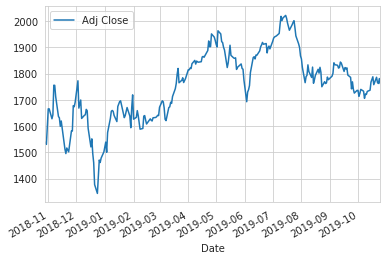

In [9]:
#ラインチャートを描画
AMZN["Adj Close"].plot(legend=True)

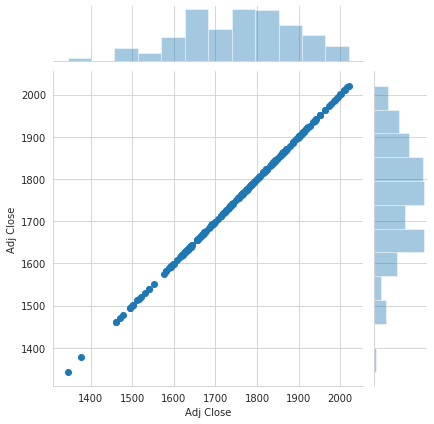

In [10]:
#Amazon同士の相関を表示
sns.jointplot('Adj Close',"Adj Close",AMZN)

In [11]:
AMZN

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-10-29,1665.739990,1495.000000,1660.000000,1538.880005,13866100,1538.880005
2018-10-30,1540.989990,1476.359985,1486.160034,1530.420044,12460100,1530.420044
2018-10-31,1623.910034,1565.089966,1569.989990,1598.010010,9390200,1598.010010
2018-11-01,1670.449951,1598.439941,1623.530029,1665.530029,8135500,1665.530029
2018-11-02,1697.439941,1651.829956,1678.589966,1665.530029,6955500,1665.530029
...,...,...,...,...,...,...
2019-10-21,1785.880005,1765.000000,1769.660034,1785.660034,2130400,1785.660034
2019-10-22,1789.780029,1762.000000,1788.150024,1765.729980,2111700,1765.729980
2019-10-23,1770.050049,1742.000000,1761.300049,1762.170044,2138200,1762.170044


In [0]:
#リスト内の銘柄の終値を１つのDataFrameに格納
close_equity_list=DataReader(equity_list,'yahoo',start,end,)["Adj Close"]

In [13]:
close_equity_list

Symbols,AMZN,GOOG,TWTR
Date,,,
2018-10-29,1538.880005,1020.080017,32.389999
2018-10-30,1530.420044,1036.209961,33.860001
2018-10-31,1598.010010,1076.770020,34.750000
2018-11-01,1665.530029,1070.000000,34.619999
2018-11-02,1665.530029,1057.790039,34.299999
...,...,...,...
2019-10-21,1785.660034,1246.150024,40.090000
2019-10-22,1765.729980,1242.800049,38.810001
2019-10-23,1762.170044,1259.130005,38.830002


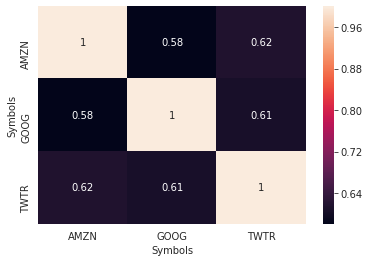

In [14]:
sns.heatmap(close_equity_list.corr(),annot=True)

In [15]:
!pip install beautifulsoup4


In [16]:
!pip install html5lib

In [0]:
#S&P全銘柄のリストを作成
url="https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_list=pd.io.html.read_html(url)

In [18]:
sp500_list_first=sp500_list[0]
sp500_list_first

,Symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,ABIOMED Inc,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...,...
500,XYL,Xylem Inc.,reports,Industrials,Industrial Machinery,"White Plains, New York",2011-11-01,1524472,NaN
501,YUM,Yum! Brands Inc,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,NaN
502,ZBH,Zimmer Biomet Holdings,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,NaN
503,ZION,Zions Bancorp,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,NaN


In [19]:
#銘柄シンボルのみを取り出したSeriesを作成
sp500_symbol=sp500_list_first["Symbol"]
sp500_symbol

0       MMM
1       ABT
2      ABBV
3      ABMD
4       ACN
       ... 
500     XYL
501     YUM
502     ZBH
503    ZION
504     ZTS
Name: Symbol, Length: 505, dtype: object

In [20]:
#listに変換
sp500_symbol_list=sp500_symbol.values.tolist()
print(sp500_symbol_list)

['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP', 'AES', 'AMG', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALXN', 'ALGN', 'ALLE', 'AGN', 'ADS', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'AIV', 'AAPL', 'AMAT', 'APTV', 'ADM', 'ARNC', 'ANET', 'AJG', 'AIZ', 'ATO', 'T', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'BKR', 'BLL', 'BAC', 'BK', 'BAX', 'BBT', 'BDX', 'BRK.B', 'BBY', 'BIIB', 'BLK', 'HRB', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BF.B', 'CHRW', 'COG', 'CDNS', 'CPB', 'COF', 'CPRI', 'CAH', 'KMX', 'CCL', 'CAT', 'CBOE', 'CBRE', 'CBS', 'CDW', 'CE', 'CELG', 'CNC', 'CNP', 'CTL', 'CERN', 'CF', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'XEC', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CTXS', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'CXO', 'COP', 'ED', 'STZ', 'COO', 'CPRT', 'GLW', 'CTVA', 'COST', 'CO

In [21]:
#yahooでは銘柄シンボルの"."は"-"に変えないとエラーになるので置換
#"."を含む要素を確認
sp500_symbol_list_in=[i for i in sp500_symbol_list if "." in i]
print(sp500_symbol_list_in)

['BRK.B', 'BF.B']


In [22]:
#置換
sp500_symbol_list_yahoo=[i.replace(".","-")for i in sp500_symbol_list]
print(sp500_symbol_list_yahoo)

sp500_symbol_list_yahoo_in=[i for i in sp500_symbol_list_yahoo if "-" in i]
print(sp500_symbol_list_yahoo_in)

['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP', 'AES', 'AMG', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALXN', 'ALGN', 'ALLE', 'AGN', 'ADS', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'AIV', 'AAPL', 'AMAT', 'APTV', 'ADM', 'ARNC', 'ANET', 'AJG', 'AIZ', 'ATO', 'T', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'BKR', 'BLL', 'BAC', 'BK', 'BAX', 'BBT', 'BDX', 'BRK-B', 'BBY', 'BIIB', 'BLK', 'HRB', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BF-B', 'CHRW', 'COG', 'CDNS', 'CPB', 'COF', 'CPRI', 'CAH', 'KMX', 'CCL', 'CAT', 'CBOE', 'CBRE', 'CBS', 'CDW', 'CE', 'CELG', 'CNC', 'CNP', 'CTL', 'CERN', 'CF', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'XEC', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CTXS', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'CXO', 'COP', 'ED', 'STZ', 'COO', 'CPRT', 'GLW', 'CTVA', 'COST', 'CO

In [23]:
#sp500銘柄の終値を１つのDataFrameに格納
close_sp500_list=DataReader(sp500_symbol_list_yahoo,'yahoo',datetime(2018, 10, 26, 7, 10, 37, 334315),datetime(2019, 10, 26, 7, 10, 37, 334315),)["Adj Close"]
close_sp500_list


Symbols,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,AFL,A,APD,AKAM,ALK,ALB,ARE,ALXN,ALGN,ALLE,AGN,ADS,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,...,UHS,UNM,VFC,VLO,VAR,VTR,VRSN,VRSK,VZ,VRTX,VIAB,V,VNO,VMC,WAB,WMT,WBA,DIS,WM,WAT,WEC,WCG,WFC,WELL,WDC,WU,WRK,WY,WHR,WMB,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-26,179.246368,65.897064,75.357407,330.350006,152.525909,68.291412,245.800003,17.629999,164.298355,14.075226,114.029617,40.810188,62.176647,145.966339,61.970001,60.166698,93.494453,117.627991,116.269997,230.130005,81.829559,173.781036,195.932297,41.565056,90.447052,1083.750000,1071.469971,59.102718,1642.810059,8.621119,62.752098,32.076912,70.380119,99.786697,39.807487,146.843552,86.589645,118.697426,83.128273,66.273109,...,115.183372,33.373829,72.955093,82.214027,110.940002,54.128933,138.669998,113.241554,53.255863,169.479996,29.142349,136.845352,64.418701,87.488869,87.859604,96.882286,74.050331,111.627480,83.334122,182.690002,66.868927,295.820007,49.344059,62.254623,42.247547,16.936314,39.656788,25.110899,100.811226,22.967327,137.016953,97.431602,47.164749,26.420042,77.671394,65.660736,84.383347,114.201118,45.325264,88.166809
2018-10-29,180.060455,66.211845,75.889076,320.029999,150.837234,64.700264,239.750000,16.850000,164.617844,14.046205,109.972992,41.377808,61.532379,147.460892,62.049999,59.706665,93.415924,119.667961,112.260002,217.940002,80.800636,170.446640,197.458038,42.311794,91.632370,1034.729980,1020.080017,60.507915,1538.880005,8.621119,63.531628,32.215256,71.637947,99.727570,38.824944,149.994217,87.845848,119.757912,84.374413,65.250160,...,118.311798,33.702633,74.583260,83.737740,110.470001,54.576908,135.320007,113.888138,54.186474,170.339996,29.608936,133.457504,65.581749,83.360435,89.499153,97.724396,74.623451,111.479553,84.786316,183.660004,67.732819,291.500000,50.287613,63.047741,39.723591,16.907475,39.074581,25.054026,100.541191,22.693459,138.347641,91.295471,48.039787,26.487564,77.247444,64.851341,84.078392,114.359825,45.792530,88.960655
2018-10-30,183.956482,66.890587,76.103607,331.220001,152.693802,66.942261,238.410004,17.200001,164.717712,14.336414,113.674294,42.219463,63.078621,150.215515,72.550003,61.899174,95.339996,120.406235,114.190002,223.009995,83.699440,157.569977,198.422684,42.521904,93.542603,1049.510010,1036.209961,61.707024,1530.420044,8.621119,63.336746,34.250950,71.879837,100.604698,39.846394,157.973862,88.503395,123.172897,85.963974,65.925507,...,120.394081,35.056549,75.861885,86.344368,112.209999,56.206779,138.660004,116.295425,55.817444,171.490005,30.765688,131.897659,65.331825,97.943573,85.057480,100.289909,76.546844,113.175812,87.151016,188.820007,67.703697,282.119995,50.730507,66.401749,39.551506,17.176611,40.888008,24.864435,107.311432,22.854006,139.155838,94.610733,48.312023,27.211002,80.895378,64.288704,85.022758,113.655563,45.656246,89.486580
2018-10-31,184.392593,67.815254,72.615105,341.200012,155.656433,68.499748,245.759995,18.209999,159.515671,14.229063,112.183907,42.150959,64.218475,150.772308,72.250000,60.117760,97.401505,118.735413,112.070000,221.199997,84.817413,154.961304,202.950623,42.003944,93.767921,1090.579956,1076.770020,60.929482,1598.010010,8.621119,62.927494,34.665993,70.980011,101.245316,40.167427,152.928909,86.884064,123.795578,86.346649,66.620720,...,121.111427,35.066212,76.239029,87.293106,119.370003,55.320354,142.539993,119.210014,54.771702,169.460007,31.086468,136.954636,65.437561,100.131546,81.500160,98.194412,77.489105,113.244843,87.788803,189.690002,66.393303,275.989990,51.250427,63.133728,41.176781,17.340014,41.012089,25.243610,105.855164,22.976772,141.107468,97.518837,47.650879,26.883047,84.168663,64.942284,88.937958,112.673538,45.802261,89.456810
2018-11-01,186.292175,69.005516,74.816414,376.940002,156.604462,68.767593,245.279999,20.219999,163.259949,14.385212,116.724159,41.955219,64.644684,151.768661,72.290001,62.339630,103